# Installing a python library into a notebook instance with internet disabled

### This notebook shows the steps to import a python library from the internet into a notebook instance where the internet is disabled.  This is needed in situations where AWS Sagemaker does not have an official version of the library (for example XGBoost)

When the internet is disabled, you can no longer import pythom libraries using the command line on the jupyter server, the conda tab of Jupyter or a lifecycle policy for the notebook instance.  In general you need to get the package (.whl file) on the jupyter server by some other means.  There are two ways to do this:

1. Getting the .whl file on the server using Jupyter upload.  This approach works well for initial testing but it relies on file storage on the notebook server, which is not perminent (disappears when notebook instance is deleted).  Git (CodeCommit) is also not a good place to store library files.  It also does not provide a central place to keep the library files for use across multiple notebooks.

2. Put the .whl files in an S3 bucket in a central place and have notebooks download the file to the notebook server.  This way there is a central place where we keep our external libraries.  This is the recommended approach.



High-level Steps for option 2:
1. Add the library wheel (.whl) file to the S3 repository we use to keep the imported python libraries.
2. Notebooks using the library will need to download the wheel file from S3, and then run pip install using the local file.

_Note that this approach will require manually tracking updated versions for these packages.  When a new version is available on PyPI, it will need to be moved to the S3 repository._

### Adding the library .whl file to the S3 repository

1. Browse the PyPI site for the library you want.  For example: https://pypi.org/project/xgboost/
2. Download the file using the icon under Navigation:
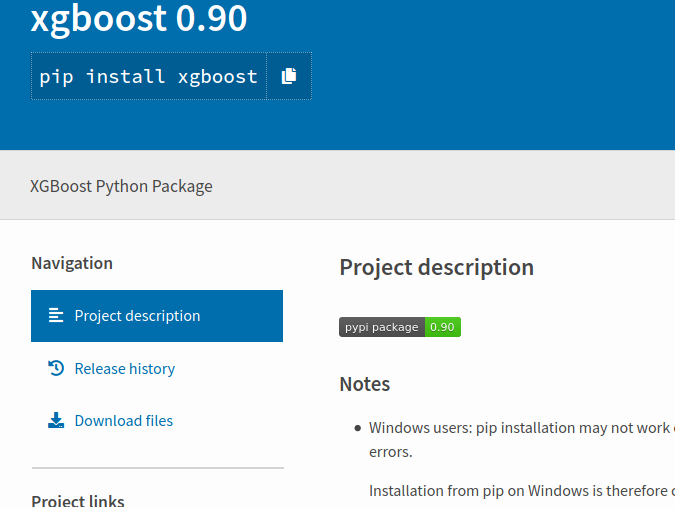


3. Upload the file to an S3 repository using the AWS Console.  For example the repository  	https://fmm-sagemaker-12-31-19.s3.us-east-2.amazonaws.com/python-install-packages/
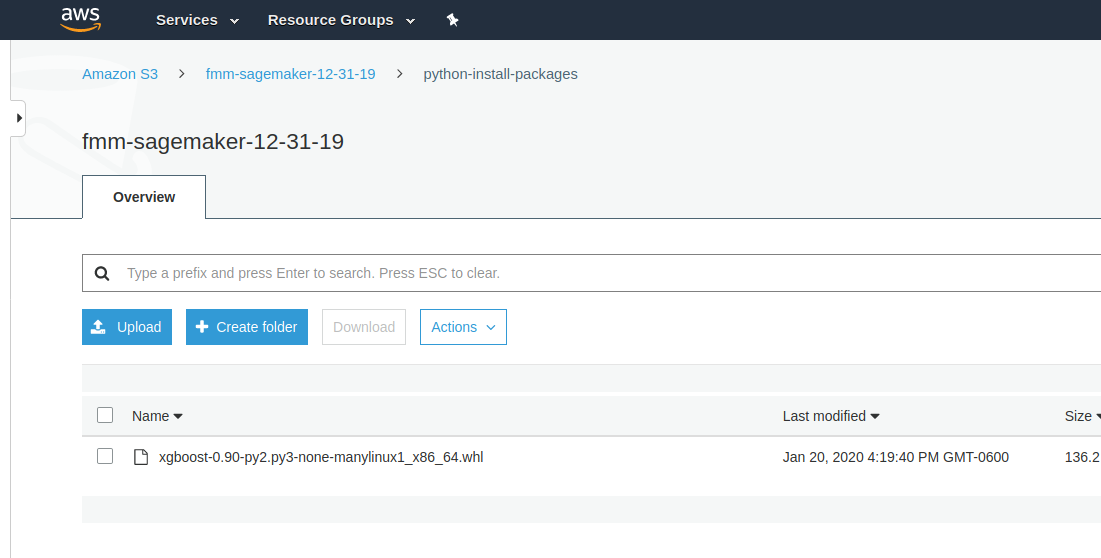

### Use the following code snippet in your notebook to: 
1. Specify the location of the .whl file on S3 (bucket, folder, file name)
2. Use boto library to download the file from S3 onto the notebook server.
3. Do the pip install of the local .whl file.
4. Remove the local whl file from the notebook server.
5. import the library as usual

Note: There is no harm in running these steps repeatedly.  If the library is already installed, it will just let you know.


In [1]:
import boto3
bucket = 'fmm-sagemaker-12-31-19' # put your s3 bucket name here
package_folder = 'python-install-packages/'
package_whl = "xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl"
#pull from s3
s3 = boto3.client('s3').download_file(bucket,package_folder+package_whl,package_whl)

#Install xgboost on the jupyter server to run locally too
!pip install {package_whl}
!rm {package_whl}

import xgboost

Processing ./xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install xgboost

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
#Test that you can not install a library that is not in S3
!pip install pywt

^C
Operation cancelled by user
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Display the list of all the libraries in S3

In [2]:
import boto3
s3c = boto3.client('s3')
blist = s3c.list_objects_v2(Bucket='fmm-sagemaker-12-31-19', Prefix='python-install-packages/')['Contents']
for it  in blist[1:]:
    print(it['Key'])

python-install-packages/attrs-19.3.0-py2.py3-none-any.whl
python-install-packages/chalice-1.14.0-py2.py3-none-any.whl
python-install-packages/enum_compat-0.0.3-py3-none-any.whl
python-install-packages/fastai-1.0.60-py3-none-any.whl
python-install-packages/opencv_python-4.2.0.34-cp36-cp36m-manylinux1_x86_64.whl
python-install-packages/tqdm-4.42.1-py2.py3-none-any.whl
python-install-packages/xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl


## Install Function
Here is a function to do installs.  It lists the dependencies found in a package

In [3]:
import boto3
import pkginfo
def install(package_whl):
    bucket = 'fmm-sagemaker-12-31-19' # put your s3 bucket name here
    package_folder = 'python-install-packages/'
    
    #pull from s3
    print("Downloading ", package_whl, " from:")
    print("s3://",bucket,'/',package_folder+package_whl)
    s3 = boto3.client('s3').download_file(bucket,package_folder+package_whl,package_whl)

    metadata = pkginfo.get_metadata(package_whl)
    print("\n\nDependencies Needed:")
    print('\n'.join(metadata.requires_dist))
    print("\n\nRunning pip\n\n")
    #Install xgboost on the jupyter server to run locally too
    !pip install {package_whl}
    print("\n\nDeleting package wheel from local server\n\n")
    !rm {package_whl}


In [5]:
install("xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl")

s3:// fmm-sagemaker-12-31-19 / python-install-packages/xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl


Dependencies Needed:
numpy
scipy


Running pip


Processing ./xgboost-0.90-py2.py3-none-manylinux1_x86_64.whl


Deleting package wheel from local server


